In [1]:
import pandas as pd
import pathlib
import sys
from functools import partial
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import warnings
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
path = str(pathlib.Path().resolve().parent)
sys.path.append(path)
sys.path.append(path+'/src/')
warnings.simplefilter("ignore")

from src.preprocessing import *

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
data = pd.read_csv(path + '/data/final_merged_dataset.csv',index_col = 0)

#Feature nb of retweets :

data['nb_retweets'] = data['tweet'].apply(count_retweets)

#Feature nb of mentions :

data['nb_mentions'] = data['tweet'].apply(count_mentions)

#Feature nb of urls:

data['nb_urls'] = data['tweet'].apply(count_urls)

#Feature nb of hashtags :

data['nb_hashtags'] = data['tweet'].apply(count_hashtags)

# Remove emojis :

data['tweet'] = data['tweet'].apply(remove_emojis)

# Remove retweets :

data['tweet'] = data['tweet'].apply(remove_retweets)

# Remove mentions :

data['tweet'] = data['tweet'].apply(remove_mentions)

# Remove urls :

#data['tweet'] = data['tweet'].apply(remove_urls)

# Remove hashtags :

data['tweet'] = data['tweet'].apply(remove_hashtags)

# Replace slash chars (\n, \t, \r) by space :

data['tweet'] = data['tweet'].apply(replace_slash_chars_by_space)

# Remove underscore :

data['tweet'] = data['tweet'].apply(remove_underscore)

# Remove html stuff (like &lt;) :

data['tweet'] = data['tweet'].apply(remove_html_stuff)

# To lowercase :

data['tweet'] = data['tweet'].apply(to_lowercase)

# Remove stopwords :

with open("../data/english_stopwords.txt",mode="r") as f:
    stopwords = f.read().split('\n')

additional_stopwords = [] # to change
to_remove_stopwords = ["no", "not", "nor", "don't", "aren't","couldn't","didn't", "doesn't","hadn't",
                       "haven't", "isn't","hasn't","mightn't","mustn't","needn't",   "shan't","shouldn't",
                       "wasn't","weren't","won't","wouldn't"] # to change

final_stopwords = [s for s in stopwords if s not in to_remove_stopwords]
final_stopwords += additional_stopwords

remove_stp_words = partial(remove_stopwords,list_stopwords=final_stopwords)

data['tweet'] = data['tweet'].apply(remove_stp_words)

# Remove additional white space :

data['tweet'] = data['tweet'].apply(remove_additional_space)

data.head()

,tweet,label,nb_retweets,nb_mentions,nb_urls,nb_hashtags
0,two weeks coronavirus media coverage and: new ...,0,1,1,0,0
1,"ever here, congratulations, immune coronavirus...",0,1,1,1,0
2,you’ve ever used frat house bathroom you’re im...,0,1,1,0,0
3,cocaine cures corona virus!! . got interesting...,0,1,1,0,0
4,it’s almost whole lot americans covid immune s...,0,1,1,0,0


Distribution du nombre de mots entre Fake news et Real news :

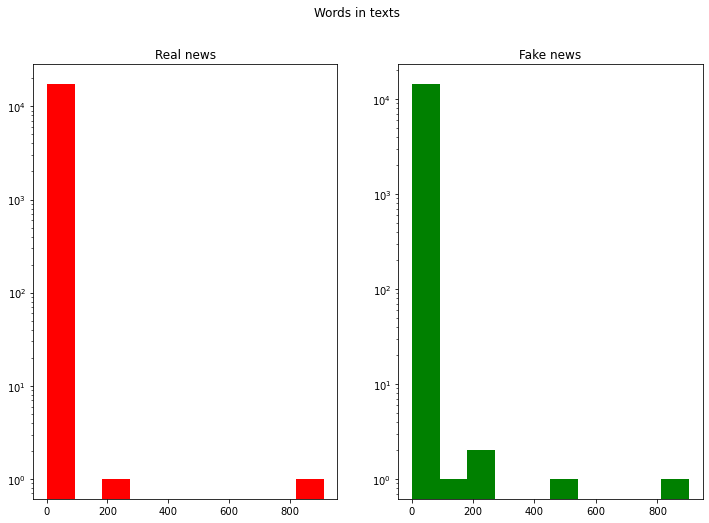

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==1]['tweet'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red',log=True)
ax1.set_title('Real news')
text_len=data[data['label']==0]['tweet'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green',log=True)
ax2.set_title('Fake news')
fig.suptitle('Words in texts')
plt.show()

Word cloud des vrai news :

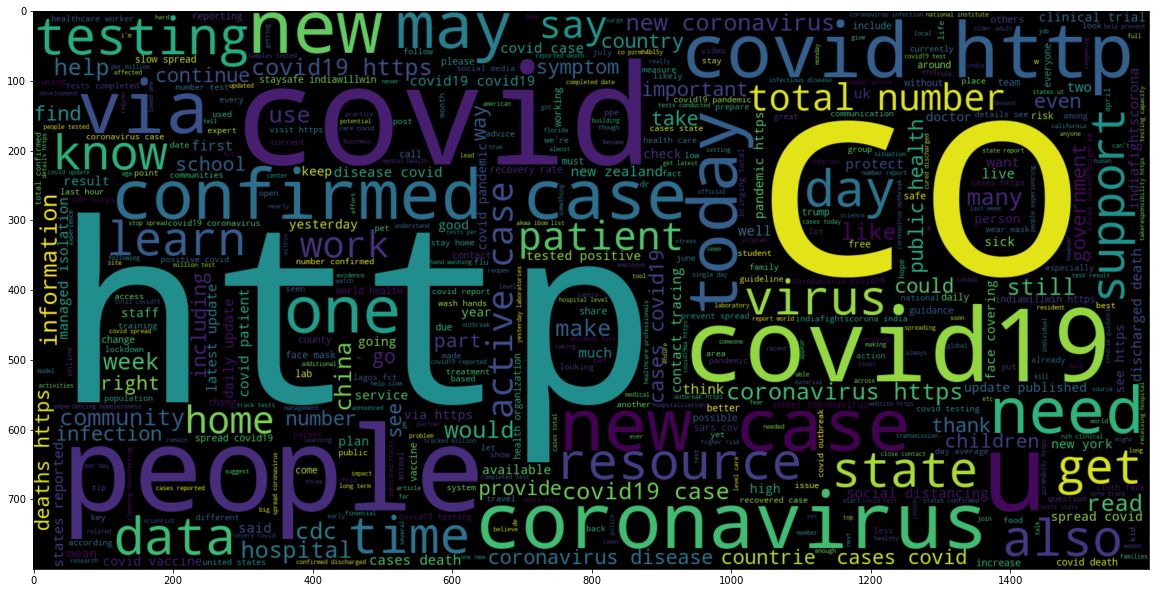

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stopwords).generate(" ".join(data[data.label == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear');

Wordcloud des fake news :

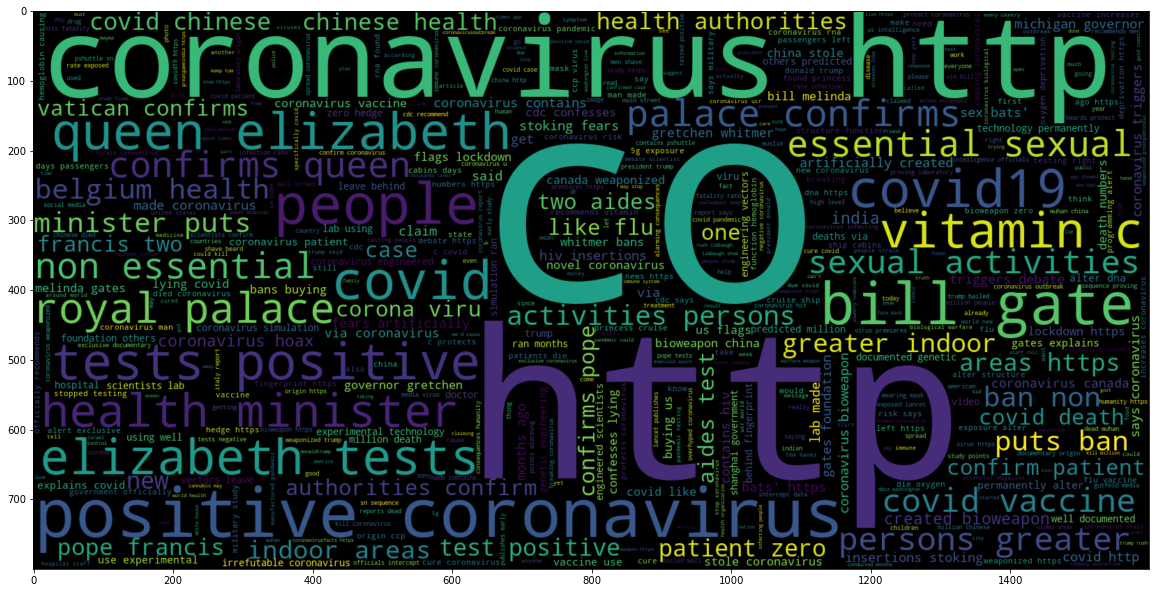

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stopwords).generate(" ".join(data[data.label == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear');

Comparaison de la longueur des mots entre fake et real news :

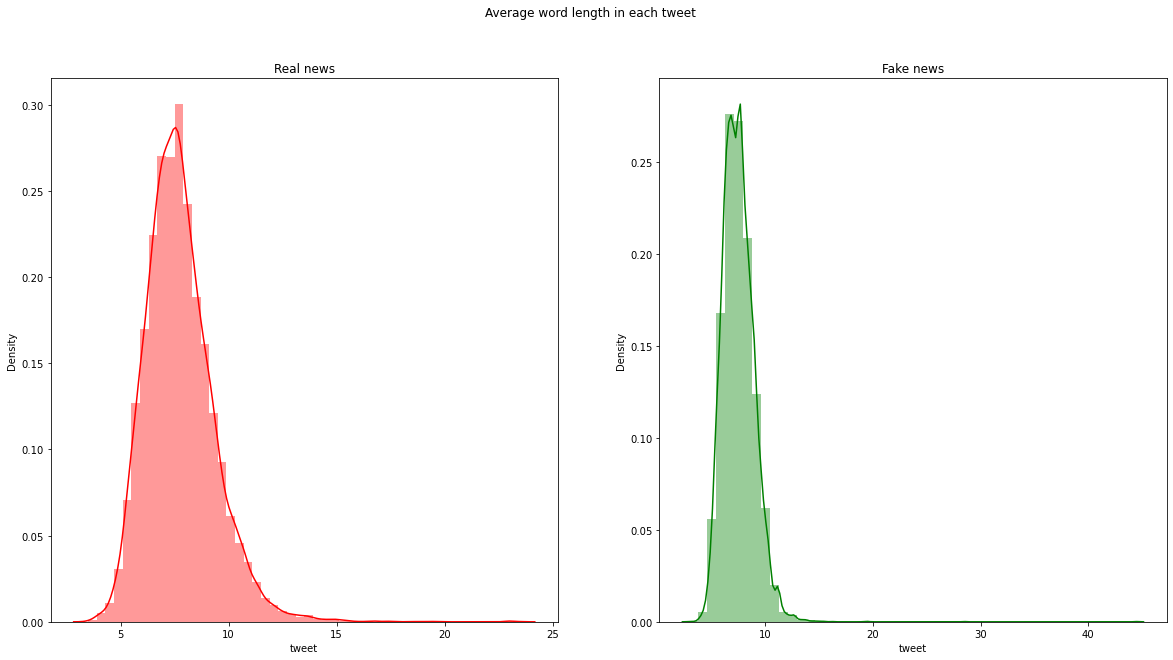

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['label']==1]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Real news')
word=data[data['label']==0]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake news')
fig.suptitle('Average word length in each tweet');

In [5]:
train_df, val_df = train_val_split(data)
X_train = train_df['tweet'].values
y_train = train_df['label'].values
X_val = val_df['tweet'].values
y_val = val_df['label'].values


In [6]:
max_words = 1000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len)
val_sequences = tok.texts_to_sequences(X_val)
val_sequences_matrix = sequence.pad_sequences(val_sequences,maxlen=max_len)

In [7]:
# load embedding matrix which is calculated below
# however the glove.6b.100d.txt file is too big to be loaded
# so we just saved the embedding matrix
embedding_dim =100
embedding_matrix = np.load("../data/embedding.dat", allow_pickle=True)

In [ ]:
# add glove embeddings

# embedding_dim =100
# embeddings_index = dict()
# f = open('../data/glove.6B.100d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:],dtype='float32')
#     embeddings_index[word]= coefs
# f.close()
#
# create embedding matrix
# embedding_matrix = np.zeros((max_words,embedding_dim))
# for word, index in tok.word_index.items():
#     if index > max_words-1:
#         break
#     else:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index]= embedding_vector
# embedding_matrix.dump("embedding.dat")

In [8]:
def RNN():
    model = tf.keras.Sequential()
    model.add(Embedding(max_words,
                    embedding_dim,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                    trainable = False
                   ))
    model.add(LSTM(units = embedding_dim,
               dropout = 0.2,
               recurrent_dropout = 0.2,
               return_sequences=True
              ))
    model.add(LSTM(units = embedding_dim,
               dropout = 0.2,
               recurrent_dropout = 0.2
              ))
    model.add(Dense(units = 1,
                activation = "sigmoid"
               ))
    return model

In [9]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

2022-02-10 21:44:13.882266: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 21:44:13.882767: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 260,901
Trainable params: 160,901
Non-trainable params: 100,000
_________________________________________________________________


In [13]:
model.fit(train_sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.1
              )

Epoch 1/10
203/203 [==============================] - 356s 2s/step - loss: 0.2689 - accuracy: 0.8888 - val_loss: 0.2518 - val_accuracy: 0.8892
Epoch 2/10
203/203 [==============================] - 345s 2s/step - loss: 0.2476 - accuracy: 0.8983 - val_loss: 0.2296 - val_accuracy: 0.9000
Epoch 3/10
203/203 [==============================] - 350s 2s/step - loss: 0.2363 - accuracy: 0.9042 - val_loss: 0.2256 - val_accuracy: 0.9031
Epoch 4/10
203/203 [==============================] - 347s 2s/step - loss: 0.2239 - accuracy: 0.9096 - val_loss: 0.2292 - val_accuracy: 0.9000
Epoch 5/10
203/203 [==============================] - 348s 2s/step - loss: 0.2170 - accuracy: 0.9127 - val_loss: 0.2121 - val_accuracy: 0.9097
Epoch 6/10
203/203 [==============================] - 356s 2s/step - loss: 0.2063 - accuracy: 0.9157 - val_loss: 0.2068 - val_accuracy: 0.9153
Epoch 7/10
203/203 [==============================] - 358s 2s/step - loss: 0.1979 - accuracy: 0.9209 - val_loss: 0.2169 - val_accuracy: 0.9090

In [14]:
y_pred = model.predict(val_sequences_matrix)
y_pred = (y_pred > 0.5).astype('int').ravel()
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1463
           1       0.91      0.92      0.92      1738

    accuracy                           0.91      3201
   macro avg       0.91      0.91      0.91      3201
weighted avg       0.91      0.91      0.91      3201

